# Project 2: Denoising Neural Network for Fashion MNIST Dataset

---
<div style="text-align: center"> Ceren Daştanoğlu - 04 May 2021 </div>

## Introduction
This report is divided into 5 parts and 14 chapters. In Parts I, II and III we will construct and analyze a Denoising Neural Network, while in Parts IV and V we will implement a "traditional" Gaussian filter.

**Part I : Training**
* *1. Goals*
* *2. Model and architecture of the network*
* *3. Data preparation*
* *4. Training procedures*

**Part II: Testing**
* *5. Test and performance evaluations*
* *6. Results, observations and conclusions*

**Part III: Code**
* *7. Complete code (parts I and II)*

**Part IV: Traditional Filtering**
* *8. Goals*
* *9. Noise adding*
* *10. Noise removing*
* *11. Test and performance evaluations*
* *12. Results, observations and conclusions*
* *13. Comparison between NN and traditional technique*

**Part V: Code**
* *14. Complete code (part IV)*



# Part I: Training


## 1. Goals
The aim of this project is to implement and train a Denoising Convolutional Autoencoder Network for image reconstruction, and to test it and analyze the results. We will use the Fashion MNIST image dataset and manually add noise to the images.

By giving noisy images as inputs to the Autoencoder NN, the encoder part will compress them, and the decoder will reconstruct the original denoised images from the compressed representation. Finally, we will see how well the model performs after training by giving it some test images for denoising and reconstruction.

## 2. Model and architecture of the network
The Autoencoder NN is divided into an encoder part and a symmetric decoder part.
* **Encoder layers**
  * *Convolutional layer 1*: input channels = 1 (grayscale image), output channels = 64 (number of kernels), kernel size = 3, padding = 1; 
  * *Convolutional layer 2*: input channels = 64, output channels = 32, kernel size = 3, padding = 1;
  * *Convolutional layer 3*: input channels = 32, output channels = 16, kernel size = 3, padding = 1;
  * *Convolutional layer 4*: input channels = 16, output channels = 8, kernel size = 3, padding = 1;
  * *Max Pooling layer*: size = 2x2;
* **Decoder layers**
  * *Transposed Convolutional layer 1*:  input channels = 8, output channels = 8, kernel size = 3, stride = 2;
  * *Transposed Convolutional layer 2*:  input channels = 8, output channels = 16, kernel size = 3, stride = 2;
  * *Transposed Convolutional layer 3*:  input channels = 16, output channels = 32, kernel size = 2, stride = 2;
  * *Transposed Convolutional layer 4*:  input channels = 32, output channels = 64, kernel size = 2, stride = 2;
  * *Convolutional layer (output)*:  input channels = 64, output channels = 1, kernel size = 3, padding = 1.

Each of the encoding layers is passed through the ReLU activation function, and there is a max pooling layer after each convolutional layer. After the last pooling layer we get the latent space code representation of the input data.

Similarly, every transposed convolutional layer is passed through the ReLU function, and the final convolutional layer uses the sigmoid activation function.

![Trained CNN Architecture](https://drive.google.com/uc?id=1cqMWn13qhPi5Cb3eMiXeJhyedJR460Pa)



## 3. Data preparation



### Imports and costants

First, we import all the useful modules.

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms

Then, we define some useful constants. We will train the network for 8 epochs, with a learning rate of 0.001 and a batch size of 16. The `VARIANCE_TRAINING` defines the amount of noise we will add to the images.

We will use the GPU for the computation if available, otherwise the CPU will be used.

In [ ]:
## TODO
# define the constants
NUM_EPOCHS = 8
LEARNING_RATE = 0.001
BATCH_SIZE = 16
VARIANCE_TRAINING = 0.001
SD_TRAINING = math.sqrt(VARIANCE_TRAINING)


## TODO
# define the device (GPU, else CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Load the data

We prepare the training set and test set.

In [ ]:
# transforms
transform = transforms.Compose([
    transforms.ToTensor(), # converting image pixel data to tensors
    transforms.Normalize((0.5,), (0.5,)), # normalizing the tensor image
])

## TODO
# 1. Load train_set and test_set (use transform=transform),
#    and define train_loader and test_loader (also
#    use shuffle=True).

train_set = torchvision.datasets.FashionMNIST(
    root="./data",
    download=True,
    train = True,
    transform = transform
)

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size = BATCH_SIZE,
    shuffle = True
)

test_set = torchvision.datasets.FashionMNIST(
    root="./data",
    download=True,
    train = False,
    transform = transform
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size = BATCH_SIZE,
    shuffle = True
)

# 2. Check training set and test set size

print("Train set size:", len(train_set))
print("Test set size:", len(test_set)) 





Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Processing...
Done!
Train set size: 60000
Test set size: 10000


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Visualize training data

Let's visualize 20 random images from the training set, with their respective label.

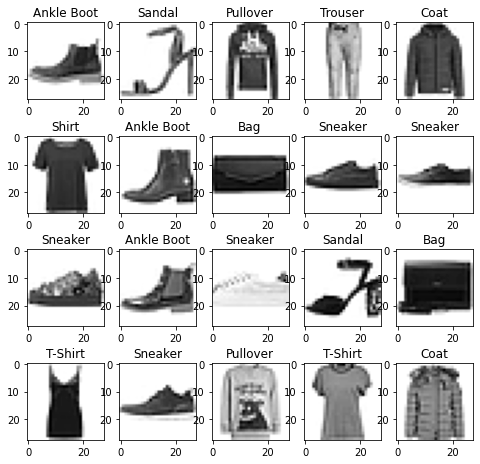

In [ ]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 5, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.imshow(img.squeeze(), cmap="gray_r")
plt.show()



## 4. Training procedures



### Define the autoencoder NN architecture

We define all the layers we will require in the `Autoencoder` class constructor, and build the neural network in the `forward()` function.

We istantiate a `model` object and print it to see the architecture.

In [ ]:
# the autoencoder network
class Autoencoder(nn.Module):

    def __init__(self):
        super(Autoencoder, self).__init__()
        ## TODO
        # Go to pytorch.org/docs/stable/nn to find the 
        # list of all pytorch layers

        # Instantiate the encoder layers (4 conv layers
        # and 1 maxpool layer) as stated in Section 2
        # ...

        self.enc1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.enc2 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.enc3 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.enc4 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)


        # Instantiate the decoder layers (4 conv transpose 
        # layers, use nn.ConvTranspose2d, and 1 conv layer) 
        # as stated in Section 2
        # ...

        self.dec1 = nn.ConvTranspose2d(8, 8, kernel_size=3, stride=2)
        self.dec2 = nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2)
        self.dec3 = nn.ConvTranspose2d(16, 32, kernel_size=2, stride=2)
        self.dec4 = nn.ConvTranspose2d(32, 64, kernel_size=2, stride=2)
        self.out = nn.Conv2d(64, 1, kernel_size=3, padding=1)




    def forward(self, x):
        ## TODO
        # Encoding
        # Remember: each of the encoding layers is passed  
        # through the ReLU activation function, and there 
        # is a max pooling layer after every conv layer.
        
        
        x = nn.functional.relu(self.enc1(x))
        x = self.pool(x)
        x = nn.functional.relu(self.enc2(x))
        x = self.pool(x)
        x = nn.functional.relu(self.enc3(x))
        x = self.pool(x)
        x = nn.functional.relu(self.enc4(x))
        x = self.pool(x)
        
        # Decoding
        # Remember: every transposed convolutional layer 
        # is passed through the ReLU function, and the 
        # final convolutional layer uses the sigmoid 
        # activation function.
        # ...
        x = nn.functional.relu(self.dec1(x))
        x = nn.functional.relu(self.dec2(x))
        x = nn.functional.relu(self.dec3(x))
        x = nn.functional.relu(self.dec4(x))
        x = torch.sigmoid(self.out(x))


        return x

# create a model

model = Autoencoder()
print(model)

Autoencoder(
  (enc1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc4): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dec1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (dec2): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
  (dec3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (dec4): ConvTranspose2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
  (out): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


### Model training

We will write the training function. First, we define the loss function, in our case the Mean Squared Error, and the optimization algorithm, Adam.

The training function loops over the epochs and batch by batch. It returns the training loss data.

In [ ]:
## TODO
# Write the loss function and the optimizer

error = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# the training function
def train(model, train_loader, NUM_EPOCHS):
    train_loss = []

    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        for data in train_loader:
            img, _ = data # we do not need the image labels

            # add noise to the image data
            img_noisy = img + SD_TRAINING * torch.randn(img.shape)

            # clip to make the values fall between 0 and 1
            img_noisy = np.clip(img_noisy, 0., 1.)

            # load the noisy images to the computation device 
            img_noisy = img_noisy.to(device)

            ## TODO
            # 1. Set the gradients to zero.
            optimizer.zero_grad()
            # 2. Feedforward pass. Remember: the MSE is calculated
            #    between the outputs and the noisy images.
            outputs = model(img_noisy)
            loss = error(outputs, img_noisy)
            # 3. Backpropagate.
            loss.backward()
            # 4. Optimize (update) the parameters.
            optimizer.step()
            
            running_loss += loss.item()

        loss = running_loss / len(train_loader)
        train_loss.append(loss)
        print('Epoch {} of {}, Train Loss: {:.4f}'.format(epoch+1, NUM_EPOCHS, loss))

    return train_loss

Notice that when we add noise to the image we use `torch.randn`, which returns a tensor filled with random numbers from a normal distribution with mean 0 and variance 1. To change the variance we defined the constant `VARIANCE_TRAINING`, and multiplied the tensor with its square root (`SD_TRAINING`), that is the standard deviation.

We call the `train` function and execute the training process.

In [ ]:
## TODO
# 1. Transfer the model to the GPU if available.
model.to(device)

# 2. Execute the training by calling the train function
#    and storing the result into a variable (it returns
#    train_loss)

train_loss = train(model, train_loader, NUM_EPOCHS)


Epoch 1 of 8, Train Loss: 0.0308
Epoch 2 of 8, Train Loss: 0.0229
Epoch 3 of 8, Train Loss: 0.0218
Epoch 4 of 8, Train Loss: 0.0211
Epoch 5 of 8, Train Loss: 0.0206
Epoch 6 of 8, Train Loss: 0.0203
Epoch 7 of 8, Train Loss: 0.0200
Epoch 8 of 8, Train Loss: 0.0197


# Part II: Testing

## 5. Test and performance evaluations



### Loss curve

We plot the training loss data over the epochs.

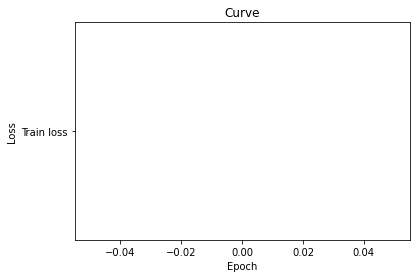

In [ ]:
## TODO
# Plot the training loss curve. The data is stored
# into the variable created in the previous step

plt.figure()
plt.plot('Train loss')
plt.title('Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### Image reconstruction

We define a new function, `test_image_reconstruction`, that adds noise to images never given as inputs to the network, and performs the image reconstructions for just one batch.

It also visualizes 5 noisy images and their reconstructions.

In [ ]:
def test_image_reconstruction(model, test_loader):
    MSE_noisy_denoised = []
    MSE_orig_denoised = []

    for batch in test_loader:
        img, _ = batch

        # add noise to the images
        img_noisy = img + SD_TRAINING * torch.randn(img.shape)
        img_noisy = np.clip(img_noisy, 0., 1.)
        img_noisy = img_noisy.to(device)

        # denoise the image with the autoencoder
        outputs = model(img_noisy)

        # calculate the MSE between noisy image and denoised image
        MSE_noisy_denoised.append(error(img_noisy, outputs))

        # copy the tensor to host memory
        outputs = outputs.view(outputs.size(0), 1, 28, 28).cpu().data
        
        # calculate the MSE between original image and denoised image
        MSE_orig_denoised.append(error(img, outputs))
        break

    # visualize original, noisy, and reconstructed images
    img_noisy = img_noisy.cpu().data
    figure = plt.figure(figsize=(16, 11))
    cols, rows = 5, 3

    for i in range(cols):
        # original images
        figure.add_subplot(rows, cols, i+1)
        img_noisy_show = img[i, :, :, :].permute(1, 2, 0)
        plt.title('image no. {}, original'.format(i+1))
        plt.imshow(torch.squeeze(img[i]), cmap="gray_r")

        # noisy images
        figure.add_subplot(rows, cols, i+cols+1)
        img_noisy_show = img_noisy[i, :, :, :].permute(1, 2, 0)
        plt.title('image no. {}, noisy\n gaussian noise var: {}'.format(i+1,
                                                                        VARIANCE_TRAINING))
        plt.imshow(torch.squeeze(img_noisy_show), cmap="gray_r")

        # denoised images
        figure.add_subplot(rows, cols, i+2*cols+1)
        outputs_show = outputs[i, :, :, :].permute(1, 2, 0)
        plt.title('image no. {}, reconstructed'.format(i+1))
        plt.imshow(torch.squeeze(outputs_show), cmap="gray_r")
    plt.show()

    # calculate and print the test MSE
    mean_MSE_noisy_denoised = sum(MSE_noisy_denoised) / len(MSE_noisy_denoised)
    print("MSE between noisy images and denoised images: {:.4f}".format(mean_MSE_noisy_denoised))
    mean_MSE_orig_denoised = sum(MSE_orig_denoised) / len(MSE_orig_denoised)
    print("MSE between original images and denoised images: {:.4f}".format(mean_MSE_orig_denoised))

Let's call the test function, print the images, and save the trained network to file.

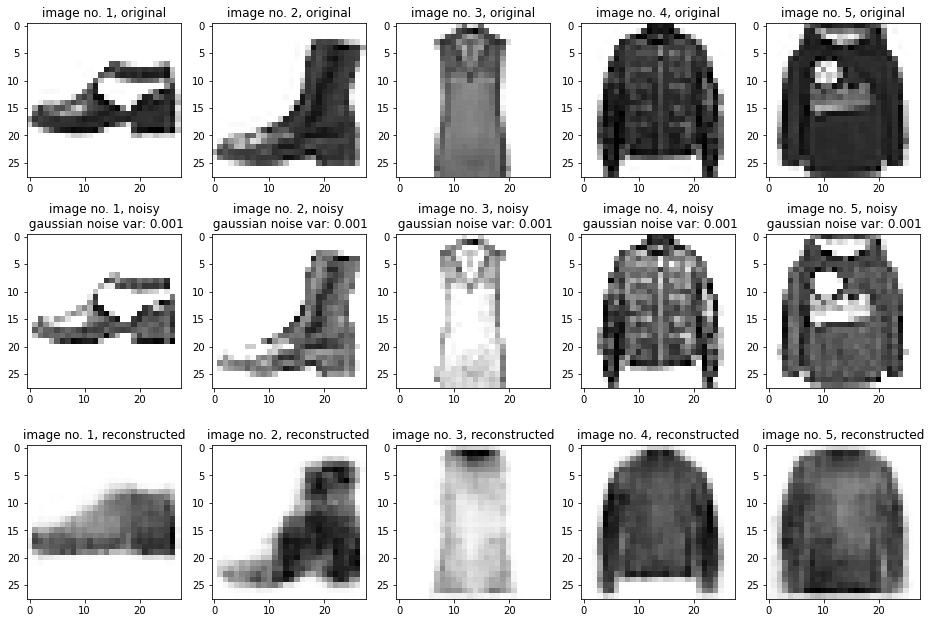

MSE between noisy images and denoised images: 0.0200
MSE between original images and denoised images: 0.6050


In [ ]:
test_image_reconstruction(model, test_loader)

## TODO
# save the trained network
torch.save(model, "saved_FashionMNIST_CNN.pt")

## 6. Results, observations and conclusions



# Part III: Code

In [ ]:
##FULL CODE

import numpy as np
import math
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms

NUM_EPOCHS = 8
LEARNING_RATE = 0.001
BATCH_SIZE = 16
VARIANCE_TRAINING = 0.001
SD_TRAINING = math.sqrt(VARIANCE_TRAINING)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

transform = transforms.Compose([
    transforms.ToTensor(), # converting image pixel data to tensors
    transforms.Normalize((0.5,), (0.5,)), # normalizing the tensor image
])


train_set = torchvision.datasets.FashionMNIST(
    root="./data",
    download=True,
    train = True,
    transform = transform
)

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size = BATCH_SIZE,
    shuffle = True
)

test_set = torchvision.datasets.FashionMNIST(
    root="./data",
    download=True,
    train = False,
    transform = transform
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size = BATCH_SIZE,
    shuffle = True
)


print("Training set size:", len(train_set))
print("Test set size:", len(test_set)) 

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 5, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.imshow(img.squeeze(), cmap="gray_r")
plt.show()

class Autoencoder(nn.Module):

    def __init__(self):
        super(Autoencoder, self).__init__()
       

        self.enc1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.enc2 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.enc3 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.enc4 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.pool = nn.maxPool2d(2, 2)

        self.dec1 = nn.ConvTranspose2d(8, 8, kernel_size=3, stride=2)
        self.dec2 = nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2)
        self.dec3 = nn.ConvTranspose2d(16, 32, kernel_size=3, stride=2)
        self.dec4 = nn.ConvTranspose2d(32, 64, kernel_size=3, stride=2)
        self.out = nn.Conv2d(64, 1, kernel_size=3, padding=1)

    def forward(self, x):
        
        # Encoding
        
        #out = torch.nn.functional.relu(self.enc1(x))
        #out = self.pool(out)
        # ...
        #out = self.pool(out) # latent space representation

        x = nn.fuctional.relu(self.enc1(x))
        x = self.pool(x)
        x = nn.fuctional.relu(self.enc2(x))
        X = self.pool(x)
        x = nn.fuctional.relu(self.enc3(x))
        X = self.pool(x)
        x = nn.fuctional.relu(self.enc4(x))
        X = self.pool(x)
        
        # Decoding
        
        x = nn.fuctional.relu(self.dec1(x))
        x = nn.fuctional.relu(self.dec2(x))
        x = nn.fuctional.relu(self.dec3(x))
        x = nn.fuctional.relu(self.dec4(x))
        x = torch.sigmoid(self.out(x))


        return out

# create a model
model = Autoencoder()
print(model)

error = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# the training function
def train(model, train_loader, NUM_EPOCHS):
    train_loss = []

    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        for data in train_loader:
            img, _ = data # we do not need the image labels

            
            img_noisy = img + SD_TRAINING * torch.randn(img.shape)
            img_noisy = np.clip(img_noisy, 0., 1.)
            img_noisy = img_noisy.to(device)

           
            optimizer.zero_grad()
           
            outputs = model(img_noisy)
            loss = error(outputs, img_noisy)
           
            loss.backward()
          
            optimizer.step()
            
            running_loss += loss.item()

        loss = running_loss / len(train_loader)
        train_loss.append(loss)
        print('Epoch {} of {}, Train Loss: {:.4f}'.format(epoch+1, NUM_EPOCHS, loss))

    return train_loss

    model.to(device)

train_loss = train(model, train_loader, NUM_EPOCHS)

plt.figure()
plt.plot('Train Loss)
plt.title('Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

def test_image_reconstruction(model, test_loader):
    MSE_noisy_denoised = []
    MSE_orig_denoised = []

    for batch in test_loader:
        img, _ = batch

        # add noise to the images
        img_noisy = img + SD_TRAINING * torch.randn(img.shape)
        img_noisy = np.clip(img_noisy, 0., 1.)
        img_noisy = img_noisy.to(device)

        # denoise the image with the autoencoder
        outputs = model(img_noisy)

        # calculate the MSE between noisy image and denoised image
        MSE_noisy_denoised.append(error(img_noisy, outputs))

        # copy the tensor to host memory
        outputs = outputs.view(outputs.size(0), 1, 28, 28).cpu().data
        
        # calculate the MSE between original image and denoised image
        MSE_orig_denoised.append(error(img, outputs))
        break

    # visualize original, noisy, and reconstructed images
    img_noisy = img_noisy.cpu().data
    figure = plt.figure(figsize=(16, 11))
    cols, rows = 5, 3

    for i in range(cols):
        # original images
        figure.add_subplot(rows, cols, i+1)
        img_noisy_show = img[i, :, :, :].permute(1, 2, 0)
        plt.title('image no. {}, original'.format(i+1))
        plt.imshow(torch.squeeze(img[i]), cmap="gray_r")

        # noisy images
        figure.add_subplot(rows, cols, i+cols+1)
        img_noisy_show = img_noisy[i, :, :, :].permute(1, 2, 0)
        plt.title('image no. {}, noisy\n gaussian noise var: {}'.format(i+1,
                                                                        VARIANCE_TRAINING))
        plt.imshow(torch.squeeze(img_noisy_show), cmap="gray_r")

        # denoised images
        figure.add_subplot(rows, cols, i+2*cols+1)
        outputs_show = outputs[i, :, :, :].permute(1, 2, 0)
        plt.title('image no. {}, reconstructed'.format(i+1))
        plt.imshow(torch.squeeze(outputs_show), cmap="gray_r")
    
    plt.show()

    # calculate and print the test MSE
    mean_MSE_noisy_denoised = sum(MSE_noisy_denoised) / len(MSE_noisy_denoised)
    print("MSE between noisy images and denoised images: {:.4f}".format(mean_MSE_noisy_denoised))
    mean_MSE_orig_denoised = sum(MSE_orig_denoised) / len(MSE_orig_denoised)
    print("MSE between original images and denoised images: {:.4f}".format(mean_MSE_orig_denoised))

    test_image_reconstruction(model, test_loader)











# Part IV: Traditional Filtering

## 8. Goals

The aim of this part of the project is to implement a "traditional" convolution to denoise images. We will add some gaussian noise to some samples from Fashion MNIST, define and apply a Gaussian filter to them, and compare this method with the results from the Convolutional Neural Network.

## 9. Noise adding



### Add gaussian noise to 5 images

We  randomly choose 5 images from the Fashion MNIST dataset and add gaussian noise to them.


In [ ]:
VARIANCE_NOISE = 0.001
SD_NOISE = math.sqrt(VARIANCE_NOISE) 
orig_imgs = []
noisy_imgs = []

for i in range(5):
    # generate a random index
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    # get an image from the training set
    img, _ = train_set[sample_idx]
    orig_imgs.append(img)

    ## TODO
    # 1. add gaussian noise to the image
    img_noisy = img + SD_NOISE* torch.randn(img.shape)

    # 2. clip the pixel values into the range [0,1] 
    img_noisy = np.clip(img_noisy, 0., 1.)
    
    noisy_imgs.append(img_noisy)

### Visualize original and noisy images

We then visualize the previously selected samples in a 2x5 grid: on the top row there are the original images, and on the bottom row the noisy images.

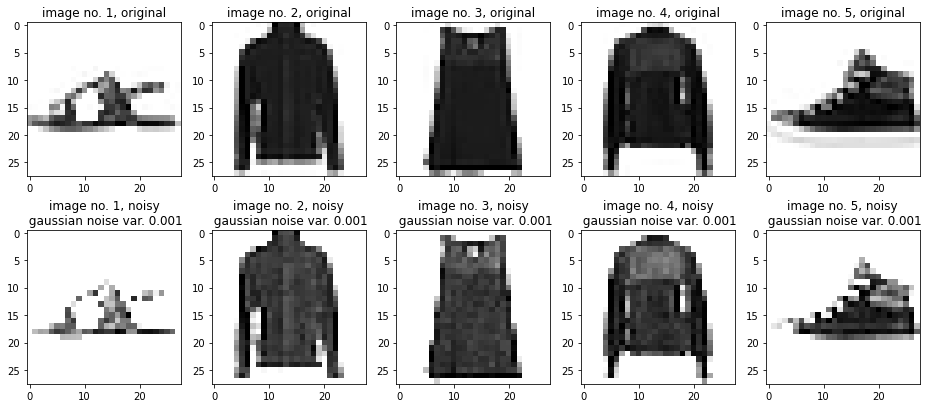

In [ ]:
# visualize original and noisy images
figure = plt.figure(figsize=(16, 7))
cols, rows = 5, 2
for i in range(cols):
    # original images
    figure.add_subplot(rows, cols, i+1)
    plt.title('image no. {}, original'.format(i+1))
    plt.imshow(torch.squeeze(orig_imgs[i]), cmap="gray_r")

    # noisy images
    figure.add_subplot(rows, cols, i+cols+1)
    plt.title('image no. {}, noisy\n gaussian noise var. {}'.format(i+1,
                                                             VARIANCE_NOISE)) 
    plt.imshow(torch.squeeze(noisy_imgs[i]), cmap="gray_r")
plt.show()

## 10. Noise removing

### Define and add a gaussian filter

We define the mask of a 3x3 gaussian filter with the `torchgeometry` package.

In [ ]:
!pip install torchgeometry

     |████████████████████████████████| 51kB 4.3MB/s 


In [ ]:
import torchgeometry as tgm

VARIANCE_FILTER = 0.5
SD_FILTER = math.sqrt(VARIANCE_FILTER)

# get gaussian filter matrix coefficients
gaussian_filter_mask = tgm.image.get_gaussian_kernel2d((3, 3), (SD_FILTER, SD_FILTER))
# add 2 dimensions to the filter for Batch and Channel
gaussian_filter_mask = gaussian_filter_mask.unsqueeze(0).unsqueeze(0)

# check if the filter shape is correct and visualize it
print(gaussian_filter_mask.shape) # [B, C, H, W]
print(gaussian_filter_mask)

torch.Size([1, 1, 3, 3])
tensor([[[[0.0449, 0.1221, 0.0449],
          [0.1221, 0.3319, 0.1221],
          [0.0449, 0.1221, 0.0449]]]])


Let's apply the gaussian filter to the 5 images.

In [ ]:
denoised_imgs = []

for i in range(5):
    # apply the layer
    out_img = nn.functional.conv2d(noisy_imgs[i].unsqueeze(0),
                                  gaussian_filter_mask, 
                                  stride=1, 
                                  padding=1)
    denoised_imgs.append(out_img)

### Visualize original, noisy, and filtered images

We visualize all the images in a 3x5 grid: on the top row there are the original images, on the second row the noisy images, and on the bottom row the denoised images.

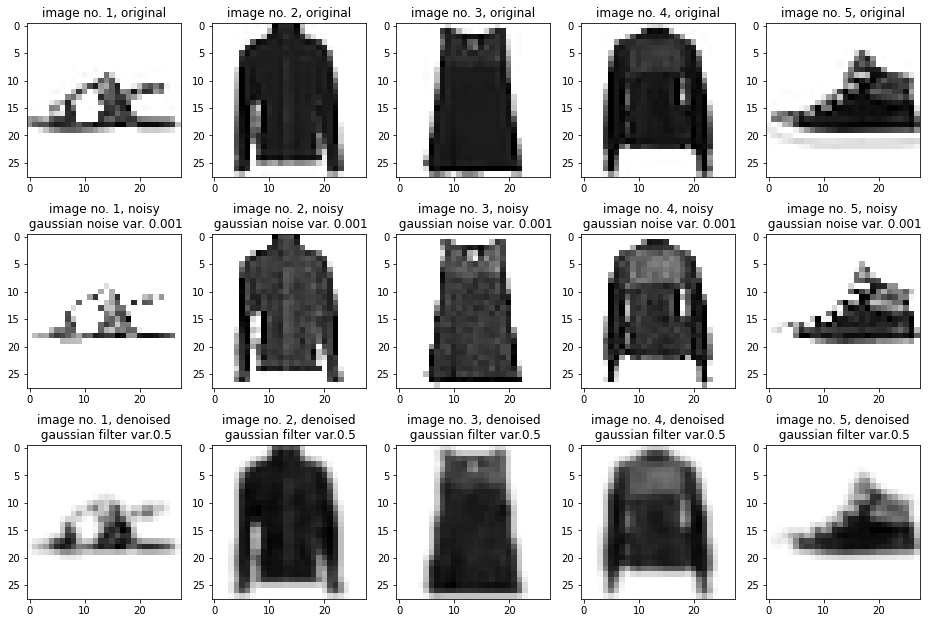

In [ ]:
## TODO
# Visualize original, noisy, and denoised images in a 3x5 grid.
# Remember to specify, when needed, in the title of each image the  
# variance of the noise and the variance of the gaussian filter.

figure = plt.figure(figsize=(16, 11))
cols, rows = 5, 3
for i in range(cols):
    # original images
    figure.add_subplot(rows, cols, i+1)
    plt.title('image no. {}, original'.format(i+1))
    plt.imshow(torch.squeeze(orig_imgs[i]), cmap="gray_r")

    # noisy images
    figure.add_subplot(rows, cols, i+cols+1)
    plt.title('image no. {}, noisy\n gaussian noise var. {}'.format(i+1,
                                                             VARIANCE_NOISE)) 
    plt.imshow(torch.squeeze(noisy_imgs[i]), cmap="gray_r")


    # denoised images
    figure.add_subplot(rows, cols, i+2*cols+1)
    plt.title('image no. {}, denoised\n gaussian filter var.{}'.format(i+1, 
                                                              VARIANCE_FILTER) )
    plt.imshow(torch.squeeze(denoised_imgs[i]), cmap="gray_r")
plt.show()

## 11. Test and performance evaluations

We compute the MSE between the noisy images and the reconstructed images, and also between the original images and the reconstructed images.

In [ ]:
def MSE_between_images(imgs_list1, imgs_list2):
    MSE_list = []
    i = 1
    # iterate through two lists of images
    for a, b in zip(imgs_list1, imgs_list2):
        error = nn.MSELoss()
        ## TODO
        # calculate the MSE
        MSE_error = error(a, b)#...
        MSE_list.append(MSE_error)
        print("MSE image {}: {:.4f}".format(i, MSE_error))
        i+=1
    ## TODO
    # calculate the average MSE
    mean_MSE = sum(MSE_list) / len(MSE_list)
    print("The average MSE is {:.4f}".format(mean_MSE))

denoised_imgs_3d = [denoised.squeeze(0) for denoised in denoised_imgs]
print("MSE between noisy images and denoised images")
MSE_between_images(noisy_imgs, denoised_imgs_3d)

print("\nMSE between original images and denoised images")
MSE_between_images(orig_imgs, denoised_imgs_3d)

MSE between noisy images and denoised images
MSE image 1: 0.0075
MSE image 2: 0.0112
MSE image 3: 0.0089
MSE image 4: 0.0099
MSE image 5: 0.0076
The average MSE is 0.0090

MSE between original images and denoised images
MSE image 1: 0.8464
MSE image 2: 0.4594
MSE image 3: 0.5331
MSE image 4: 0.5018
MSE image 5: 0.7080
The average MSE is 0.6098


## 12. Results, observations and conclusions


## 13. Comparison between NN and traditional technique

We implemented both a Denoising Convolutional Autoencoder Network for image reconstruction and a "traditional" convolution to denoise images, and analyzed the results.

To summarize the outcomes of these two techniques, we can visualize in a single figure an original image, the same image with added noise, and the denoised figure both with the neural network and with the gaussian filter.

In [ ]:
def compare_denoising_techniques(model, train_set, std_dev, filter_mask):
    # select a random image from the training set
    idx = torch.randint(len(train_set), size=(1,)).item()
    original, _ = train_set[idx]

    # add gaussian noise
    noisy_img = original + torch.randn(original.shape) * std_dev
    noisy_img = np.clip(noisy_img, 0., 1.)

    # denoise the image with the nn
    noisy_img_nn = noisy_img.to(device)
    denoised_nn = model(noisy_img_nn.unsqueeze(0))
    denoised_nn = denoised_nn.view(denoised_nn.size(0), 1, 28, 28).cpu().data

    # denoise the image with the gaussian filter
    denoised_classic = nn.functional.conv2d(noisy_img.unsqueeze(0),
                                            filter_mask, 
                                            stride=1, 
                                            padding=1)

    # visualize the 4 images
    figure = plt.figure(figsize=(12, 8))
    # original
    figure.add_subplot(1, 4, 1)
    plt.title("original")
    plt.imshow(torch.squeeze(original), cmap="gray_r")
    # noisy
    figure.add_subplot(1, 4, 2)
    plt.title("noisy")
    plt.imshow(torch.squeeze(noisy_img), cmap="gray_r")
    # denoised with nn
    figure.add_subplot(1, 4, 3)
    plt.title("denoised NN")
    plt.imshow(torch.squeeze(denoised_nn), cmap="gray_r")
    # denoised with gaussian filter
    figure.add_subplot(1, 4, 4)
    plt.title("denoised classic")
    plt.imshow(torch.squeeze(denoised_classic), cmap="gray_r")

    plt.show()

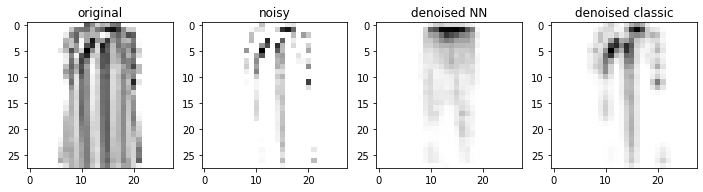

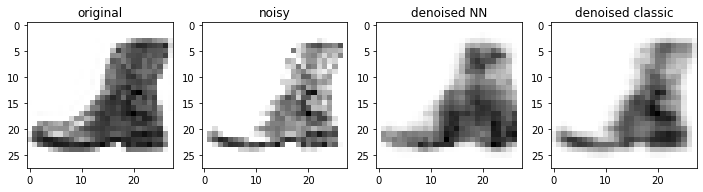

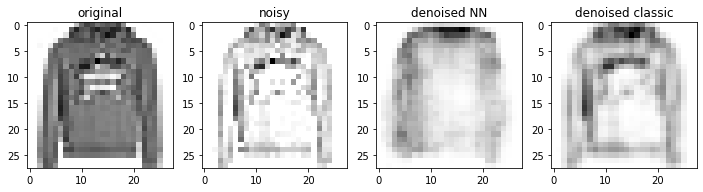

In [ ]:
N = 3 #how many different samples to visualize
for i in range(N):
    compare_denoising_techniques(model, train_set, SD_NOISE, gaussian_filter_mask)

# Part V: Code

**Conclusions**

As a result of the project I found out how to denoise images but I ran into errors which were not easy to fix for me as I did not know how to write a code for denoising but after this project, I understood the basics of denoising.

## 14. Full code (part IV)

In [ ]:
VARIANCE_NOISE = 0.04
SD_NOISE = math.sqrt(VARIANCE_NOISE) 
orig_imgs = []
noisy_imgs = []
 
for i in range(5):
    # generate a random index
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    # get an image from the training set
    img, _ = train_set[sample_idx]
    orig_imgs.append(img)
 
    #  add gaussian noise to the image
    img_noisy = img + SD_NOISE* torch.randn(img.shape)
    #  clip the pixel values into the range [0,1] 
    img_noisy = np.clip(img_noisy, 0., 1.)
 
    noisy_imgs.append(img_noisy) 

 
figure = plt.figure(figsize=(16, 7))
cols, rows = 5, 2
for i in range(cols):
    # original images from train_set
    figure.add_subplot(rows, cols, i+1)
    plt.title('image no. {}, original'.format(i+1))
    plt.imshow(torch.squeeze(orig_imgs[i]), cmap="gray_r")
 
    # noisy images
    figure.add_subplot(rows, cols, i+cols+1)
    plt.title('image no. {}, noisy\n gaussian noise var. {}'.format(i+1,
                                                             VARIANCE_NOISE)) 
    plt.imshow(torch.squeeze(noisy_imgs[i]), cmap="gray_r")
plt.show()
 

 
!pip install torchgeometry
 
import torchgeometry as tgm
 
VARIANCE_FILTER = 0.04
SD_FILTER = math.sqrt(VARIANCE_FILTER)
 
# get gaussian filter matrix coefficients
gaussian_filter_mask = tgm.image.get_gaussian_kernel2d((3, 3), (SD_FILTER, SD_FILTER))
# add 2 dimensions to the filter for Batch and Channel
gaussian_filter_mask = gaussian_filter_mask.unsqueeze(0).unsqueeze(0)
 
# check if the filter shape is correct and visualize it
print(gaussian_filter_mask.shape) # [B, C, H, W]
print(gaussian_filter_mask)
 
 
figure = plt.figure(figsize=(16, 11))
cols, rows = 5, 3
for i in range(cols):
    # original images
    figure.add_subplot(rows, cols, i+1)
    plt.title('image no. {}, original'.format(i+1))
    plt.imshow(torch.squeeze(orig_imgs[i]), cmap="gray_r")
 
    # noisy images
    figure.add_subplot(rows, cols, i+cols+1)
    plt.title('image no. {}, noisy\n gaussian noise var. {}'.format(i+1,
                                                             VARIANCE_NOISE)) 
    plt.imshow(torch.squeeze(noisy_imgs[i]), cmap="gray_r")
 
 
    # denoised images
    figure.add_subplot(rows, cols, i+2*cols+1)
    plt.title('image no. {}, denoised\n gaussian filter var.{}'.format(i+1, 
                                                              VARIANCE_FILTER) )
    plt.imshow(torch.squeeze(denoised_imgs[i]), cmap="gray_r")
    plt.show()
 
 
 
def MSE_between_images(imgs_list1, imgs_list2):
    MSE_list = []
    i = 1
    # iterate through two lists of images
    for a, b in zip(imgs_list1, imgs_list2):
        error = nn.MSELoss()
 
        # calculate the MSE
        MSE_error = error(a, b)
        MSE_list.append(MSE_error)
        print("MSE image {}: {:.4f}".format(i, MSE_error))
        i+=1
    ## TODO
    # calculate the average MSE
    mean_MSE = sum(MSE_list) / len(MSE_list)
    print("The average MSE is {:.4f}".format(mean_MSE))
 
denoised_imgs_3d = [denoised.squeeze(0) for denoised in denoised_imgs]
print("MSE between noisy images and denoised images")
MSE_between_images(noisy_imgs, denoised_imgs_3d)
 
print("\nMSE between original images and denoised images")
MSE_between_images(orig_imgs, denoised_imgs_3d)
 
 
 
 
def compare_denoising_techniques(model, train_set, std_dev, filter_mask):
    # select a random image from the training set
    idx = torch.randint(len(train_set), size=(1,)).item()
    original, _ = train_set[idx]
 
    # add gaussian noise
    noisy_img = original + torch.randn(original.shape) * std_dev
    noisy_img = np.clip(noisy_img, 0., 1.)
 
    # denoise the image with the nn
    noisy_img_nn = noisy_img.to(device)
    denoised_nn = model(noisy_img_nn.unsqueeze(0))
    denoised_nn = denoised_nn.view(denoised_nn.size(0), 1, 28, 28).cpu().data
 
    # denoise the image with the gaussian filter
    denoised_classic = nn.functional.conv2d(noisy_img.unsqueeze(0),
                                            filter_mask, 
                                            stride=1, 
                                            padding=1)
 
    # visualize the 4 images
    figure = plt.figure(figsize=(12, 8))
    # original
    figure.add_subplot(1, 4, 1)
    plt.title("original")
    plt.imshow(torch.squeeze(original), cmap="gray_r")
    # noisy
    figure.add_subplot(1, 4, 2)
    plt.title("noisy")
    plt.imshow(torch.squeeze(noisy_img), cmap="gray_r")
    # denoised with nn
    figure.add_subplot(1, 4, 3)
    plt.title("denoised NN")
    plt.imshow(torch.squeeze(denoised_nn), cmap="gray_r")
    # denoised with gaussian filter
    figure.add_subplot(1, 4, 4)
    plt.title("denoised classic")
    plt.imshow(torch.squeeze(denoised_classic), cmap="gray_r")
 
    plt.show()

    N = 3 #how many different samples to visualize
for i in range(N):
    compare_denoising_techniques(model, train_set, SD_NOISE, gaussian_filter_mask)

---
## Bibliography

1. [Netron](https://netron.app/) - Visualizer for neural network, deep learning, and machine learning models.
2. [Autoencoder Neural Network: Application to Image Denoising](https://debuggercafe.com/autoencoder-neural-network-application-to-image-denoising/)